In [15]:
import pandas as pd

file_path = "mensa_export_2015-2025.csv"
df = pd.read_csv(file_path, sep=';')
# Alle unique Gerichte darstellen
unique_dishes = df['Gericht'].str.strip().unique()

print("Gerichte:")
for dish in unique_dishes:
    print(f"- {dish}")

Gerichte:
- zwei Stücken Backfisch8 Fi Gl Sf
- paniertes PutenschnitzelGl
- Hähnchenstreifen in RahmspinatGl La Mi
- Rindfleisch-Burger mit CheddarkäseLa Mi Sf
- 1 Quinoa-Erbsen-Frikadelle (vegan)Sl
- Gemüse mit Couscous und Nüssen (vegan)Gl Nu
- Kaiserschmarrn (vegetarisch)Ei Gl La Mi
- Tomatensauce mit Frischkäse (vegetarisch)La Mi
- Paprikasauce mit RinderhackLa Mi Sl So
- HühnerfrikasseeGl La Mi
- Hähnchenbruststreifen
- Gyros-ReispfanneSo
- Seelachsfilet in Backteig8 Fi Gl La Mi Sf
- Schnitzel in ZwiebelbackteigGl
- Tomatensauce mit getrockneten Tomaten und Champignons (vegan)So
- vegane Soljanka klein3 9 Sf So
- vegane Soljanka gross3 9 Sf So
- Tomatensauce mit HackbällchenEi Gl.Wz La Mi
- ein Brathering ohne Mittelgräte9 Fi Gl.Wz
- Bratkartoffeln (vegan)
- Seelachsfilet, gebratenFi Gl.Wz
- halbes Grillhähnchen
- Putencurry mit KichererbsenLa Mi Nu.Ma Sf Sl
- Bandnudeln mit Rucola und Tomaten (vegan)Gl.Wz
- Grünkernbolognese (vegan)Gl.Di Sl
- Eieromelette mit Gemüse und Käse3 Ei 

In [16]:
# Teuerstes und günstigstes Gericht
melted_df = df.melt(
    id_vars=['Gericht'],
    value_vars=['Studentenpreis', 'Bedienstetenpreis', 'Gästepreis'],
    var_name='Price Type',
    value_name='Price'
)
melted_df['Price'] = (
    melted_df['Price']
    .astype(str)
    .str.replace(',', '.')
    .pipe(pd.to_numeric, errors='coerce')
)

melted_df = melted_df.dropna(subset=['Price'])
guestigst = melted_df.loc[melted_df['Price'].idxmin()]
teuerstes = melted_df.loc[melted_df['Price'].idxmax()]

print("Günstigstes Gericht:")
print(f"- Gericht: {guestigst['Gericht'].strip()}\n  Preis: {guestigst['Price']} € ({guestigst['Price Type']})")
print("\nTeuerstes Gericht:")
print(f"- Gericht: {teuerstes['Gericht'].strip()}\n  Preis: {teuerstes['Price']} € ({teuerstes['Price Type']})")

Günstigstes Gericht:
- Gericht: ein HefekloßEi Gl
  Preis: 0.15 € (Studentenpreis)

Teuerstes Gericht:
- Gericht: 0,7l Prosecco DOC | Rotkäppchen Sekt trocken o. alkoholfrei
  Preis: 16.0 € (Studentenpreis)


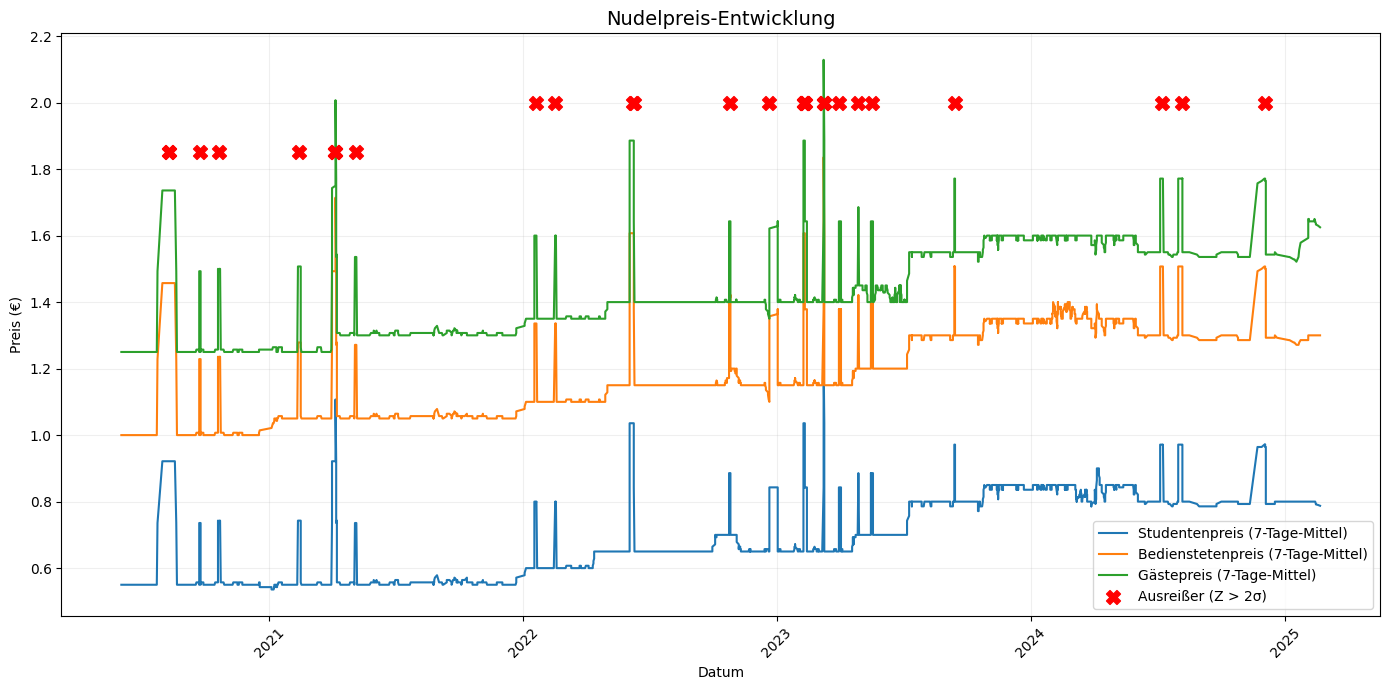

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

nudeln_df = df[df['Gericht'].str.contains('NudelnGl.Wz', case=False, na=False)].copy()
nudeln_df['Datum'] = pd.to_datetime(nudeln_df['Datum'])
nudeln_df.sort_values('Datum', inplace=True)

# Rolling Mean (7-Tage Durchschnitt)
for price_col in ['Studentenpreis', 'Bedienstetenpreis', 'Gästepreis']:
    nudeln_df[f'{price_col}_rolling'] = nudeln_df[price_col].rolling(
        window=7,  # 7-Tage-Gleitmittel
        min_periods=1,
        center=True
    ).mean()

# Outlier dectection
# Ausreißer mit Z-Score identifizieren (> 2σ)
# Mehr als zwei Standardabweichungen über dem Durchschnittspreis -> Raus!
z_scores = np.abs(stats.zscore(nudeln_df[['Studentenpreis', 'Bedienstetenpreis', 'Gästepreis']]))
outliers = (z_scores > 2).any(axis=1)

plt.figure(figsize=(14, 7))

# Glatte Linien (Rolling Mean)
for col in ['Studentenpreis', 'Bedienstetenpreis', 'Gästepreis']:
    plt.plot(
        nudeln_df['Datum'],
        nudeln_df[f'{col}_rolling'],
        label=f'{col} (7-Tage-Mittel)',
        linestyle='-'
    )

# Ausreißer als Punkte plotten
plt.scatter(
    nudeln_df[outliers]['Datum'],
    nudeln_df[outliers]['Studentenpreis'],
    color='red',
    marker='X',
    s=100,
    label='Ausreißer (Z > 2σ)',
    zorder=10
)

plt.title('Nudelpreis-Entwicklung', fontsize=14)
plt.xlabel('Datum')
plt.ylabel('Preis (€)')
plt.legend()
plt.grid(alpha=0.2)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
